In [1]:
%matplotlib inline
from cv2 import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from tqdm import tqdm_notebook as tqdm
import time

root = './input_data/A2_resources/'

In [2]:
def read_img(name, gray=False):
    fg = cv2.imread(name)
    fg = cv2.cvtColor(fg, cv2.COLOR_BGR2RGB)
    if gray: fg = cv2.cvtColor(fg, cv2.COLOR_RGB2GRAY)
    return fg

def plot(imgs, gray=False, titles=[], FigSize=(20,8), vmap=None):
    fig = plt.figure(figsize=FigSize)
    if len(imgs)>=3: num_plots = (np.ceil(len(imgs)/3.0),3)
    else: num_plots = (np.ceil(len(imgs)/3.0),len(imgs))
        
    vflag = True
    for i in range(len(imgs)):
        ax = fig.add_subplot(*num_plots, i+1)
        if not (vmap!=None and vflag):
            vflag=False
            vmap={}
            vmap['vmin']=np.min(imgs[i])
            vmap['vmax']=np.max(imgs[i])
        
        if not gray: ax.imshow(imgs[i])
        else: ax.imshow(imgs[i], cmap='gray', **vmap)
            
        ax.axis("off")            
        if i<len(titles): ax.title.set_text(titles[i])


In [3]:
def multilayer(func, img, *args, **kwargs):
    fimg = []
    for i in range(3):
        fimg.append(func(img[:,:,i], *args, **kwargs))
    
    return np.uint8(np.dstack(fimg))

def im2col(img, windowSize, stride=1):
    n,m = img.shape
    x,y = windowSize
    
    rowc = n-x+1
    colc = m-y+1
    
    st = np.arange(rowc)[::stride, np.newaxis]*m + np.arange(colc)[::stride] 
    en = np.arange(x)[:,np.newaxis]*m + np.arange(y) 
    
    return img.ravel()[en.ravel()[:, np.newaxis] + st.ravel()]
    
    
def conv2D(img, fil, stride=1, size='same', padding='edge'):
    
        
    img = np.float64(img) 
    fil = np.float64(fil)    
    
    n,m = img.shape
    x,y = fil.shape
    
    if size=='same':
        pv = n*(stride-1)-1+x
        ph = m*(stride-1)-1+y
        
        img = np.pad(img, ((pv//2, pv-pv//2), (ph//2, ph-ph//2)), padding)
        n,m = img.shape
        
    rowc = n-x+1
    colc = m-y+1
    
    img_vec = im2col(img, fil.shape, stride)
    fil_vec = fil.ravel()[:, np.newaxis]
    
    fimg_vec = fil_vec.T @ img_vec
    
    return np.uint8(np.clip(fimg_vec.reshape((rowc, colc)), 0, 255))
    
    
def conv2DRaw(img, fil, stride=1, size='same', padding='edge'):
    
        
    img = np.float64(img) 
    fil = np.float64(fil)    
    
    n,m = img.shape
    x,y = fil.shape
    
    if size=='same':
        pv = n*(stride-1)-1+x
        ph = m*(stride-1)-1+y
        
        img = np.pad(img, ((pv//2, pv-pv//2), (ph//2, ph-ph//2)), padding)
        n,m = img.shape
        
    rowc = n-x+1
    colc = m-y+1
    
    img_vec = im2col(img, fil.shape, stride)
    fil_vec = fil.ravel()[:, np.newaxis]
    
    fimg_vec = fil_vec.T @ img_vec
    
    return fimg_vec.reshape((rowc, colc))

---
<div width="100%" align="center"> <h1>Q1</h1></div>

---

In [4]:
img = read_img(root+'bell.jpg', gray=False)
img2 = read_img(root+'cubes.png', gray=False)
img3 = read_img(root+'barbara.jpg', gray=True)

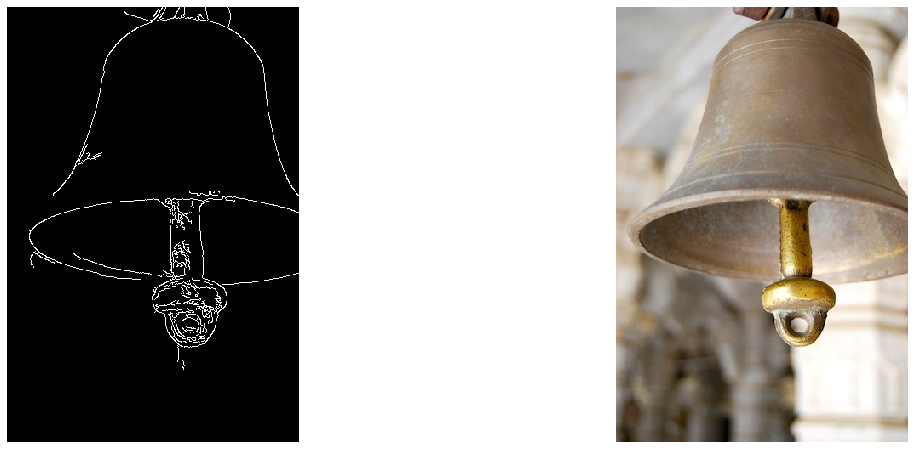

In [5]:
plot([cv2.Canny(img, 50, 400,L2gradient=False), img], gray=True)

### Parameters for Best Value
$minVal = 50$  
$maxVal = 400$

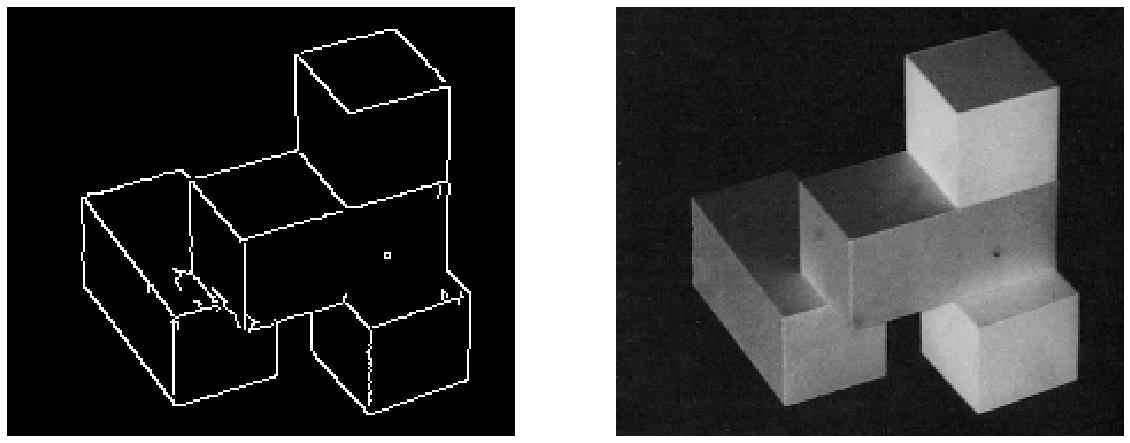

In [6]:
plot([cv2.Canny(img2, 50, 150,L2gradient=False), img2], gray=True)

### Parameters for Best Value
$minVal = 50$  
$maxVal = 150$

## 2.

In [7]:
img = read_img(root+'barbara.jpg', gray=True)

In [8]:
fil = []
fil.append( (np.array([[-1,0,1], [-1,0,1],[-1,0,1]]),'PREWITT_X') )
fil.append( (np.array([[1,1,1], [0,0,0],[-1,-1,-1]]),'PREWITT_Y') )

fil.append( (np.array([[-1,0,1], [-2,0,2],[-1,0,1]]),'SOBEL_X') )
fil.append( (np.array([[1,2,1], [0,0,0],[-1,-2,-1]]),'SOBEL_Y') )

fil.append( (np.array([[0,1],[-1,0]]), 'ROBERTS_X') )
fil.append( (np.array([[1,0],[0,-1]]), 'ROBERTS_Y') )

fil.append( (np.array([[0,1,0],[1,-4,1],[0,1,0]]), 'LAPLACIAN_EDGE') )
fil.append( (np.array([[1,1,1],[1,-8,1],[1,1,1]]), 'LAPLACIAN_DIAGONALS') )


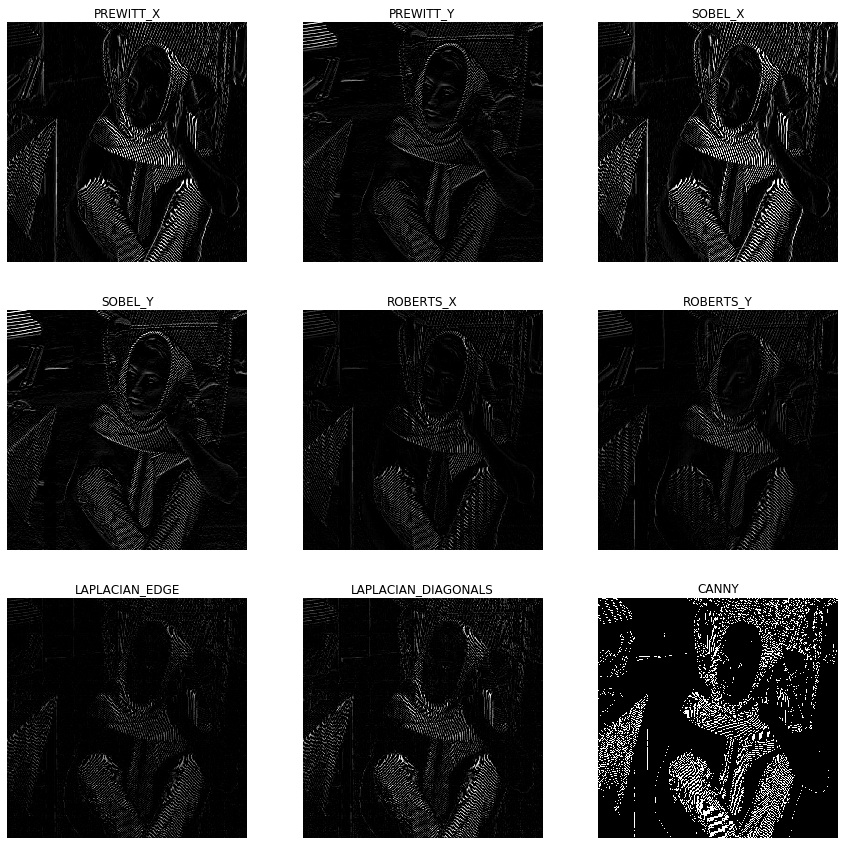

In [9]:
imgs = []
titles = []
for i in fil:
    imgs.append(conv2D(img, i[0]))
    titles.append(i[1])

imgs.append(cv2.Canny(img, 50,150,L2gradient=False))
titles.append('CANNY')

plot(imgs, titles=titles, gray=True, FigSize=(15,15))

### OBSERVATIONS
1. Both Prewitt and Sobel filters have similar strong responses. They also capture a lot of minute facial features.
2. Laplacian filters with diagonals has a stringer reponse than just laplacian. Laplacian is unable to capture much facial features
3. Robert has neither a strong response, nor is it able to capure any facial information. Also there appear to be a striation sort of effect(bars in the image).
4. Canny captures the facial features well, but not as well as sobel and prewitt.

## 3.

In [10]:
img = read_img(root+'barbara.jpg', gray=True)
img = np.uint8(np.float64(img) + np.random.normal(0, 10, img.shape))

In [11]:
fil = []
fil.append( (np.array([[-1,0,1], [-1,0,1],[-1,0,1]]),'PREWITT_X') )
fil.append( (np.array([[1,1,1], [0,0,0],[-1,-1,-1]]),'PREWITT_Y') )

fil.append( (np.array([[-1,0,1], [-2,0,2],[-1,0,1]]),'SOBEL_X') )
fil.append( (np.array([[1,2,1], [0,0,0],[-1,-2,-1]]),'SOBEL_Y') )

fil.append( (np.array([[0,1],[-1,0]]), 'ROBERTS_X') )
fil.append( (np.array([[1,0],[0,-1]]), 'ROBERTS_Y') )

fil.append( (np.array([[0,1,0],[1,-4,1],[0,1,0]]), 'LAPLACIAN_EDGE') )
fil.append( (np.array([[1,1,1],[1,-8,1],[1,1,1]]), 'LAPLACIAN_DIAGONALS') )


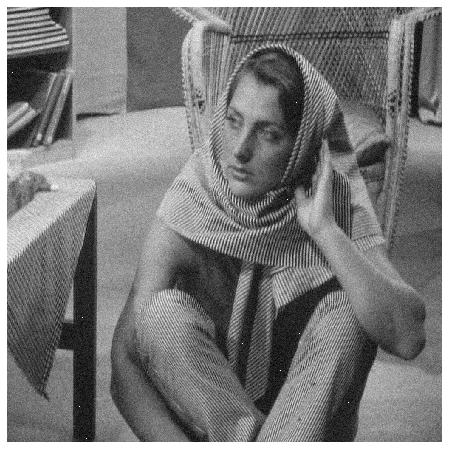

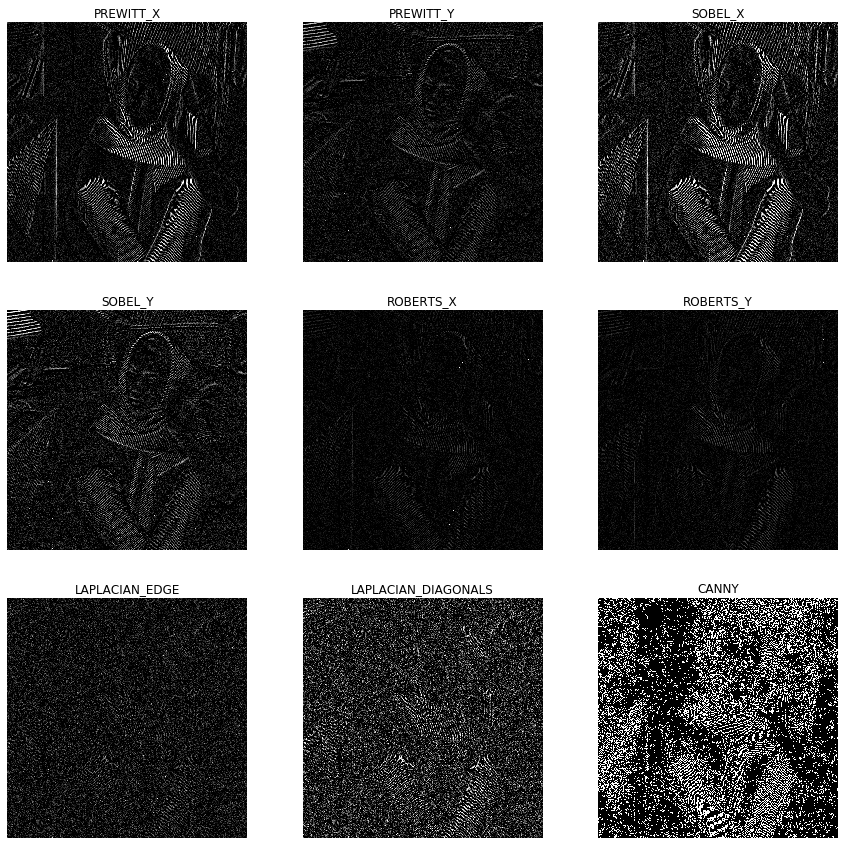

In [12]:
imgs = []
titles = []
for i in fil:
    imgs.append(conv2D(img, i[0]))
    titles.append(i[1])

imgs.append(cv2.Canny(img, 50,150,L2gradient=False))
titles.append('CANNY')

plot([img], gray=True)
plot(imgs, titles=titles, gray=True, FigSize=(15,15))

### OBSERVATIONS
1. Laplacian and Canny completely fail to detect any edges.
2. Sobel and Prewitt filters still manage to show many edges, though their output is also noisy.

---
<div width="100%" align="center"> <h1>Q2</h1></div>

---

![Solution](Q2.jpg)

---
<div width="100%" align="center"> <h1>Q3</h1></div>

---

## 1.

In [13]:
img = read_img(root+'box.png', gray=True)

### Kernel

$$
\begin{matrix}
-1&-1&-1\\
0&0&0\\
1&1&1\\
\end{matrix}
$$

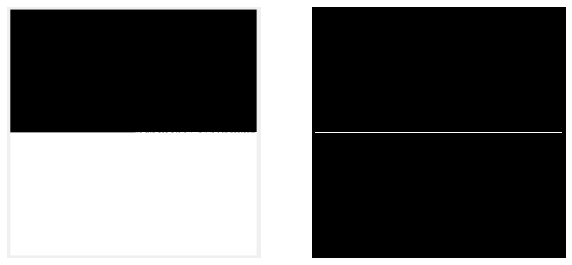

In [14]:
fil = np.array([[-1,-1,-1], [0,0,0],[1,1,1]])

fimg = conv2D(img,fil)
plot([img, fimg], gray=True, vmap={'vmin':0, 'vmax':255}, FigSize=(10,10))

## 2.

In [15]:
img = read_img(root+'blur.jpg', gray=True)

#### Horizontal Edge Detector

In [16]:
fil = np.array([[-1,-1,-1], [0,0,0],[1,1,1]])

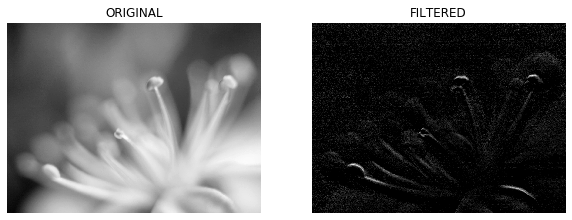

In [17]:
fimg = conv2D(img,fil)
plot([img, fimg], gray=True, FigSize=(10,10), titles=['ORIGINAL', 'FILTERED'])

#### Verticle Edge Detector

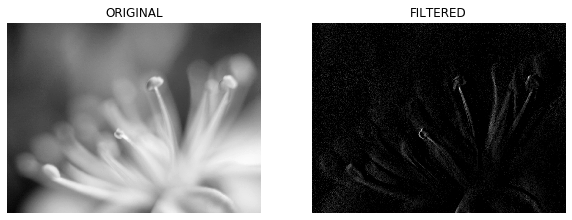

In [18]:
fimg = conv2D(img,fil.T)
plot([img, fimg], gray=True, FigSize=(10,10), titles=['ORIGINAL', 'FILTERED'])

### Observations
***Note: The filtered images have been normalised for better visibility***
1. The horizontal edge detector gives a higher value when we move from the white stalks to the darker(relatively) background **vertically, bottom to top**. 
2. The vertical edge detector gives a higher value when we move from the white stalks to the darker(relatively) background **horizontally, right to left**.

## 3.

In [19]:
img = read_img(root+'cubes.png', gray=True)

In [20]:
fil = np.array([[-1,-1,-1], [0,0,0],[1,1,1]])

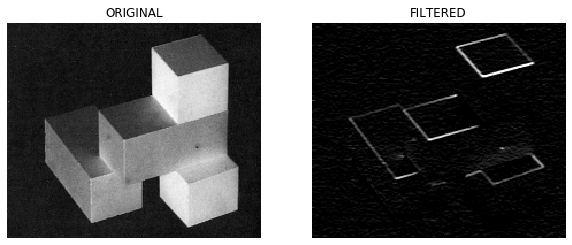

In [21]:
fimg = conv2D(img,fil)
plot([img, fimg], gray=True, FigSize=(10,10), titles=['ORIGINAL', 'FILTERED'])

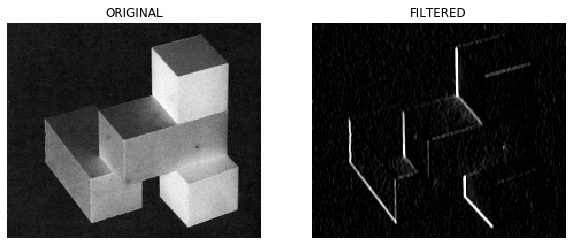

In [22]:
fimg = conv2D(img,fil.T)
plot([img, fimg], gray=True, FigSize=(10,10), titles=['ORIGINAL', 'FILTERED'])

---
<div width="100%" align="center"> <h1>Q4</h1></div>

---

## 1.

***Please use the interactive sliders to change k (the weight factor) and windowSize (of the gaussian blur for the $g_{mask}$)*** 

In [4]:
img = read_img(root+'bell.jpg', gray=True)

In [5]:
def high_boost(img, windowSize=3, k=1, Plot=True, ret=False):
    img = np.float64(img)
    gaussian_kernel = np.exp((-np.power(np.arange(-windowSize//2+1, windowSize//2+1),2)[:,None] -\
                             np.power(np.arange(-windowSize//2+1,windowSize//2+1),2))/(2))
    gaussian_kernel = gaussian_kernel/gaussian_kernel.sum()
    hp = img-conv2D(img, gaussian_kernel) 
    fimg = np.uint8(np.clip(img + k*hp, 0,255))
    if Plot:
        plot([img, fimg], gray=True, titles=['ORIGINAL', 'BOOSTED'], FigSize=(10,10))
    
    if ret: return fimg 
    

In [6]:
interact(high_boost, img=fixed(img), windowSize=(3,11,2), k=(0,10,0.5), Plot=fixed(True), ret=fixed(False))


interactive(children=(IntSlider(value=3, description='windowSize', max=11, min=3, step=2), FloatSlider(value=1…

<function __main__.high_boost(img, windowSize=3, k=1, Plot=True, ret=False)>

### Observations
1. A higher value of k(weight factor) leads to a more pronounced effect on the edges. Ie, even some fainter edges become visible.
2. A larger window size does not have much effect on the image, this is because the value of gaussian falls off rapidly as we move away from the center.

## 2.

In [26]:
img = read_img(root+'cubes.png', gray=True)

In [27]:
interact(high_boost, img=fixed(img), windowSize=(3,11,2), k=(0,5,0.5), Plot=fixed(True), ret=fixed(False))

interactive(children=(IntSlider(value=3, description='windowSize', max=11, min=3, step=2), FloatSlider(value=1…

<function __main__.high_boost(img, windowSize=3, k=1, Plot=True, ret=False)>

### Observations
1. As K increases the edges become more prominent. 
2. it seems that some noise is also added or enhanced in the image.

## 3. Bilateral filter vs high-boost filter

1. High-boost filtering is an sharpening ***whereas*** bilateral filtering is a noise reducing, smoothening technique.  
2. High-boost filtering uses a fixed kernel ***whereas*** bilateral filtering uses an image aware kernel that changes according to where it is in the image.
3. High-boost filtering can add noise ***whereas*** bilateral filtering is used to reduce noise in an image.

---
<div width="100%" align="center"> <h1>Q5</h1></div>

---

## 1.

In [28]:
img = read_img(root+'../inputs/bigImg.jpg', gray=True)
# img = read_img(root+'barbara.jpg', gray=True)

In [29]:
def naiveAvgFilter(img, k, Plot=True):
    m,n = img.shape
    
    r=m-k+1
    c=n-k+1
    
    img = np.float64(img)
    fimg = np.zeros((r,c))
    
    for i in range(r):
        for j in range(c):
            fimg[i,j] = img[i:i+k, j:j+k].mean()
    
    fimg = np.uint8(fimg)
    if Plot:
        plot([img, fimg], gray=True, titles=['ORIGINAL', 'FILTERED'])
    
    return fimg

In [30]:
a = naiveAvgFilter(img, 3, Plot=False)

## 2.

In [31]:
def optAvgFilter(img, k, Plot=True):
    m,n = img.shape
    
    r=m-k+1
    c=n-k+1
    
    img = np.float64(img)
    fimg = np.zeros((r,c))
    
    col_sum = img[0:k,:].sum(axis=0)
    row_sum = np.cumsum(img, axis = 1)
    
    fimg[0,0] = img[0:k,0:k].sum()
    
    for i in range(1,c):
        fimg[0][i] = fimg[0][i-1] + col_sum[i+k-1] - col_sum[i-1]
    
    st = np.arange(c)
    en = st+k-1
    
    for i in range(1,r):
        fimg[i, :] = fimg[i-1,:] + (row_sum[i+k-1,k-1:] - row_sum[i+k-1, :c] + img[i+k-1, :c])[None, :] - \
                    (row_sum[i-1,k-1:] - row_sum[i-1, :c] + img[i-1, :c])[None, :]
        
    fimg = np.uint8(fimg/(k*k))
    return fimg

In [32]:
b = optAvgFilter(img, 3)

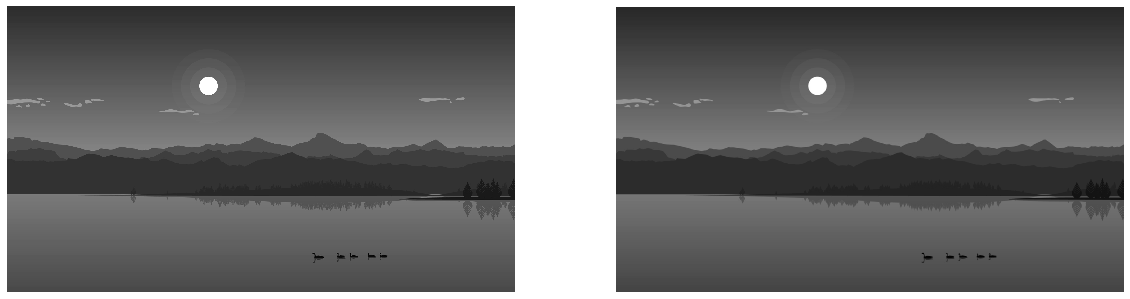

In [33]:
plot([img,b], gray=True)

In [34]:
def comp(img, max_k):
    nt = []
    ot = []
    for k in tqdm(range(2,max_k)):
        st = time.time()
        naiveAvgFilter(img, k, Plot=False)
        en = time.time()
        nt.append(en-st)

        st=time.time()
        optAvgFilter(img, k)
        en = time.time()
        ot.append(en-st)
    
    return nt,ot

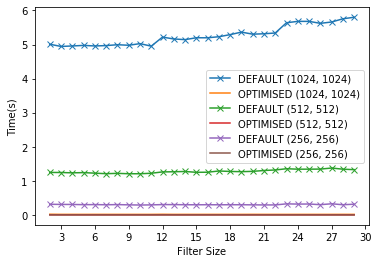

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)

img = read_img(root+'barbara.jpg', gray=True)
max_k = 30
nt,ot = comp(img, max_k)
ax.plot(np.arange(2,max_k), np.array(nt), '-x', label='DEFAULT {}'.format(img.shape))
ax.plot(np.arange(2,max_k), np.array(ot), label='OPTIMISED {}'.format(img.shape))

img = img[:512,:512]
nt,ot = comp(img, max_k)
ax.plot(np.arange(2,max_k), np.array(nt), '-x', label='DEFAULT {}'.format(img.shape))
ax.plot(np.arange(2,max_k), np.array(ot), label='OPTIMISED {}'.format(img.shape))


img = img[:256,:256]
nt,ot = comp(img, max_k)
ax.plot(np.arange(2,max_k), np.array(nt), '-x', label='DEFAULT {}'.format(img.shape))
ax.plot(np.arange(2,max_k), np.array(ot), label='OPTIMISED {}'.format(img.shape))

# img = img[:128,:128]
# nt,ot = comp(img, max_k)
# ax.plot(np.arange(2,max_k), np.array(nt), '-x', label='DEFAULT {}'.format(img.shape))
# ax.plot(np.arange(2,max_k), np.array(ot), label='OPTIMISED {}'.format(img.shape))


ax.set_xlabel("Filter Size")
ax.set_ylabel("Time(s)")

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.legend()

## 3.

In [36]:
img = read_img(root+'Degraded.jpg', gray=True)
# img = np.random.randint(0,256, size=(10,10))


In [37]:
def naiveMedianFilter(img, k=3, Plot=True):
    m,n = img.shape
    
    r=m-k+1
    c=n-k+1
    
    img = np.float64(img)
    fimg = np.zeros((r,c))
    
    for i in range(r):
        for j in range(c):
            fimg[i,j] = np.median(fimg[i:i+k-1, j:j-k+1])
            
    return np.uint8(fimg)

In [38]:
def getMedian(H, k):
    H = np.cumsum(H)
    if k%2==0:
        return ((H>=k/2).argmax()+(H>=k/2+1).argmax())/2.0
    else:
        return (H>=k//2+1).argmax()
    
def optMedianFilter(img, k=3, Plot=True):
    m,n = img.shape
    
    r=m-k+1
    c=n-k+1
    
    img = np.float64(img)
    fimg = np.zeros((r,c))
    
    h = np.zeros((n,256))
    
    for i in range(n):
        vals, counts = np.unique(img[0:k-1, i], return_counts=True)
        h[i,np.int32(vals)] = counts
    
    H = np.zeros(256)
        
    for i in range(r):
        h = h.ravel()
        h[np.int32(np.arange(n)*256+img[i+k-1,:])] += 1
        h = h.reshape(n,256)
        
        H = h[0:k, :].sum(axis=0)
        fimg[i, 0] = getMedian(H,k*k)
        for j in range(1,c):
            H = H + h[j+k-1, :] - h[j-1,:]
            fimg[i,j] = getMedian(H,k*k)
            
        h = h.ravel()
        h[np.int32(np.arange(n)*256+img[i,:])] -= 1
        h = h.reshape(n,256)
        
    return np.uint8(fimg )

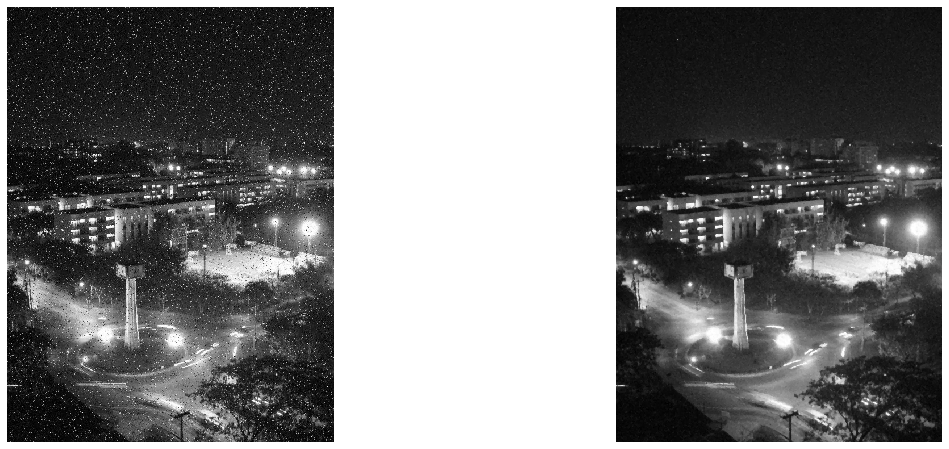

In [39]:
a = optMedianFilter(img, 3)
plot([img, a], gray=True)

In [40]:
def compMedian(img, max_k):
    ot = []
    nt = []
    for k in tqdm(range(2,max_k)):
        st = time.time()
        naiveMedianFilter(img, k, Plot=False)
        en = time.time()
        nt.append(en-st)
        
        st=time.time()
        optMedianFilter(img, k)
        en = time.time()
        ot.append(en-st)
    
    return ot,nt

/media/altitude/hdd/projects/envs/dip/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/media/altitude/hdd/projects/envs/dip/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


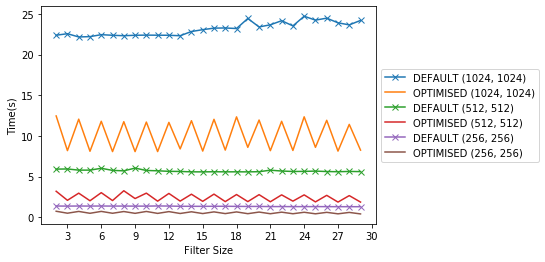

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)

img = read_img(root+'barbara.jpg', gray=True)
max_k = 30
ot,nt = compMedian(img, max_k)
ax.plot(np.arange(2,max_k), np.array(nt), '-x', label='DEFAULT {}'.format(img.shape))
ax.plot(np.arange(2,max_k), np.array(ot), label='OPTIMISED {}'.format(img.shape))

img = img[:512,:512]
ot,nt = compMedian(img, max_k)
ax.plot(np.arange(2,max_k), np.array(nt), '-x', label='DEFAULT {}'.format(img.shape))
ax.plot(np.arange(2,max_k), np.array(ot), label='OPTIMISED {}'.format(img.shape))


img = img[:256,:256]
ot,nt = compMedian(img, max_k)
ax.plot(np.arange(2,max_k), np.array(nt), '-x', label='DEFAULT {}'.format(img.shape))
ax.plot(np.arange(2,max_k), np.array(ot), label='OPTIMISED {}'.format(img.shape))

# img = img[:128,:128]
# nt,ot = comp(img, max_k)
# ax.plot(np.arange(2,max_k), np.array(nt), '-x', label='DEFAULT {}'.format(img.shape))
# ax.plot(np.arange(2,max_k), np.array(ot), label='OPTIMISED {}'.format(img.shape))


ax.set_xlabel("Filter Size")
ax.set_ylabel("Time(s)")

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

---
<div width="100%" align="center"> <h1>Q6</h1></div>

---

## 1. Bilateral Filtering

In [42]:
img = read_img(root+'sky.png', gray=False)
img2 = read_img(root+'noir.png', gray=False)
img3 = read_img(root+'Degraded.jpg', gray=False)

In [43]:
def bilateralFilter(img, sigmad, sigmar, k=3, Plot=True):
    if k%2 ==0 :
        print("only odd kernels")
        return None
    
    img = np.float64(img)
    
    im_vec = []
    
    fimg = None
    if len(img.shape)==3:
        fimg = np.zeros((img.shape[0]-k+1, img.shape[1]-k+1, img.shape[2]))
        for i in range(0,img.shape[2]):
            im_vec.append(im2col(img[:,:,i], windowSize=(k,k)))
    else:
        fimg = np.zeros((img.shape[0]-k+1, img.shape[1]-k+1))
        im_vec.append(im2col(img[:,:], windowSize=(k,k)))
        
    
    gaussian_kernel = np.exp((-np.power(np.arange(-k//2+1, k//2+1),2)[:,None] -\
                             np.power(np.arange(-k//2+1,k//2+1),2))/(2*sigmad*sigmad))
    gaussian_kernel = gaussian_kernel.ravel()[:,None]
    
    
    for i in range(len(im_vec)):      
        range_filtered = np.exp(-np.power((im_vec[i][:,:] - im_vec[i][k//2, :]), 2)/(2*sigmar*sigmar))
        norm = gaussian_kernel.T @ range_filtered
        range_filtered = range_filtered/norm

        I_dash = np.multiply(im_vec[i],range_filtered)

        if len(fimg.shape)==3:
            fimg[:,:,i] = (gaussian_kernel.T @ I_dash).reshape(fimg.shape[:2])
        else:
            fimg[:,:] = (gaussian_kernel.T @ I_dash).reshape(fimg.shape[:2])
            
    if Plot:
        plot([np.uint8(img), np.uint8(fimg)], gray=True)
    return np.uint8(fimg)

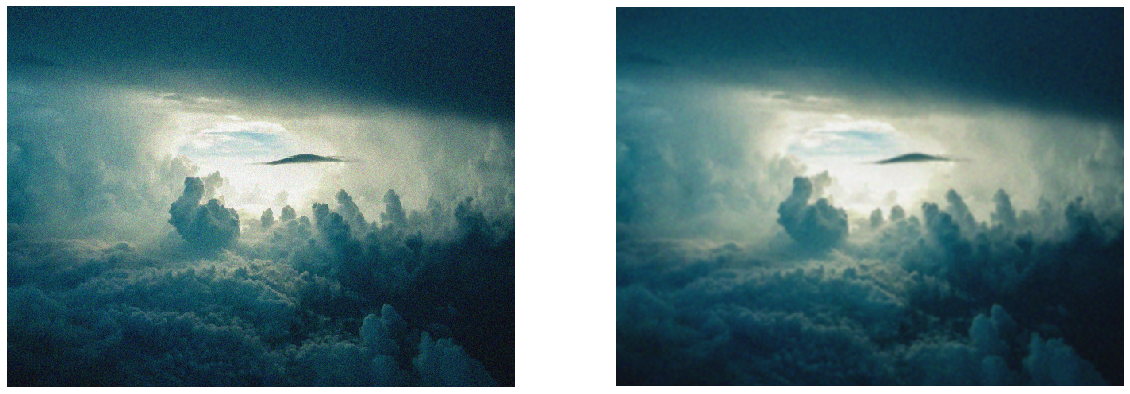

In [44]:
a = bilateralFilter(img,sigmad = 1.5,sigmar = 400,k=5)

In [45]:
img_gt = read_img(root+'gt_sky.png')
np.sqrt(np.sum((img_gt[2:img_gt.shape[0]-2,2:img_gt.shape[1]-2,:]-a)**2))

5682.255538076407

### Parameters
$
\sigma_d = 1.5\\
\sigma_r = 400\\
windowSize = 5\\
rms\_from\_gt = 5682.255538076407
$

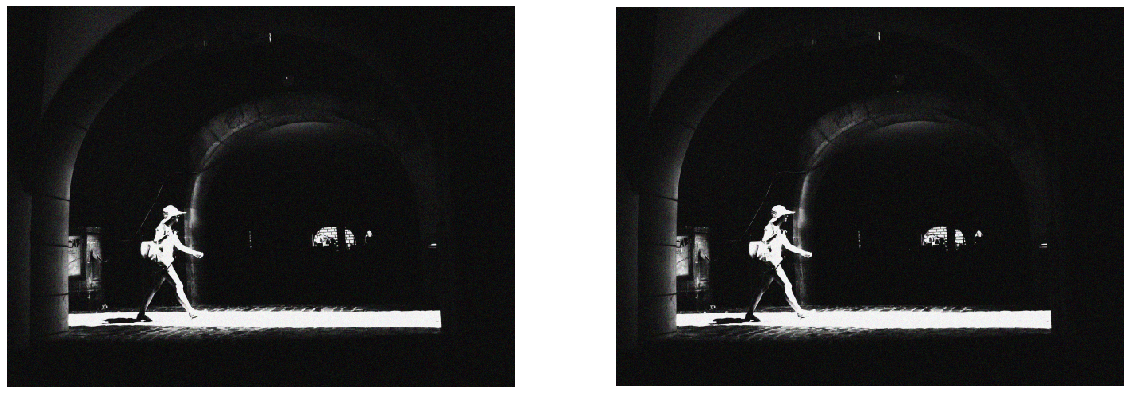

In [46]:
a = bilateralFilter(img2,sigmad = 0.1,sigmar =500,k=5)

In [47]:
img_gt = read_img(root+'gt_noir.png')
np.sqrt(np.sum((img_gt[2:img_gt.shape[0]-2,2:img_gt.shape[1]-2,:]-a)**2))

8967.541413341785

### Parameters
$
\sigma_d = 0.1\\
\sigma_r = 500\\
windowSize = 5\\
rms\_from\_gt = 8967.541413341785
$

---
<div width="100%" align="center"> <h1>Q7</h1></div>

---

## 1. 

In [48]:
img_flash = read_img(root+'pots_flash.jpg')
img_no_flash = read_img(root+'pots_no_flash.jpg')

In [49]:
def crossBilateralFilter(img1, img2, sigmad, sigmar, k=3, Plot=True):
    if k%2 ==0 :
        print("only odd kernels")
        return None
    
    img1 = np.float64(img1)
    img2 = np.float64(img2)
    
    im_vec1 = []
    im_vec2 = []
    
    im_vec1.append(im2col(img1[:,:,0], windowSize=(k,k)))
    im_vec2.append(im2col(img2[:,:,0], windowSize=(k,k)))
    
    if len(img.shape)==3:
        for i in range(1,img.shape[2]):
            im_vec1.append(im2col(img1[:,:,i], windowSize=(k,k)))
            im_vec2.append(im2col(img2[:,:,i], windowSize=(k,k)))
            
    gaussian_kernel = np.exp((-np.power(np.arange(-k//2+1, k//2+1),2)[:,None] -\
                             np.power(np.arange(-k//2+1,k//2+1),2))/(2*sigmad*sigmad))
    gaussian_kernel = gaussian_kernel.ravel()[:,None]
    
    fimg = np.zeros((img1.shape[0]-k+1, img1.shape[1]-k+1, img1.shape[2]))
    
    for i in range(len(im_vec1)):      
        range_filtered = np.exp(-np.power((im_vec2[i][:,:] - im_vec2[i][k//2, :]), 2)/(2*sigmar*sigmar))
        norm = gaussian_kernel.T @ range_filtered
        range_filtered = range_filtered/norm

        I_dash = np.multiply(im_vec1[i],range_filtered)

        fimg[:,:,i] = (gaussian_kernel.T @ I_dash).reshape(fimg.shape[:2])
    
    if Plot: plot([np.uint8(img1), np.uint8(img2), np.uint8(fimg)], gray=True)
    return np.uint8(fimg)

In [50]:
a = crossBilateralFilter(img_no_flash,img_flash,5,150,5, Plot=False)

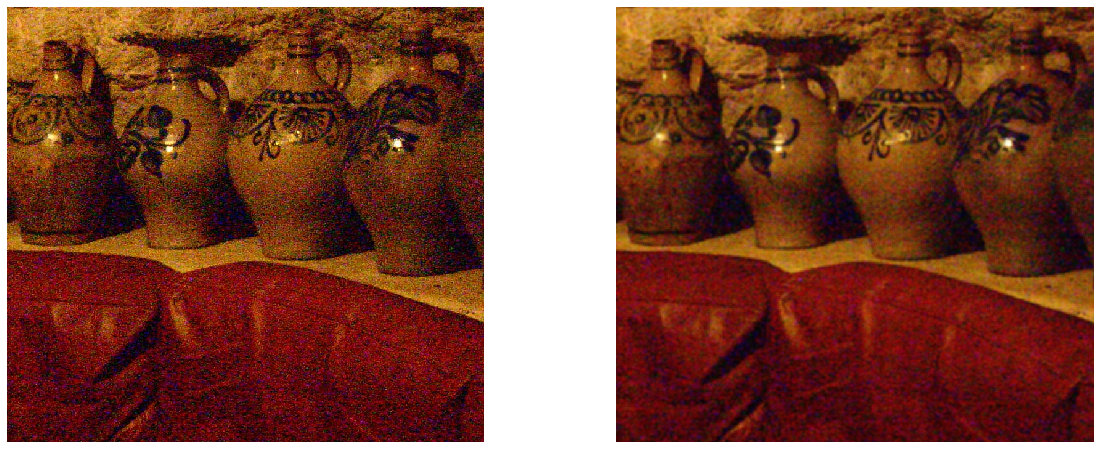

In [51]:
plot([img_no_flash, a])

### Parameters Used
$\sigma_d = 5$  
$\sigma_r = 150$  
$windowSize = 5$  

## 2.

>It makes sense to have an inverse bilateral filter. Bilateral filter, preserves edges by having a range filter which prevents steps edges from getting blurred. It does this by giving lower weight to the pixels whose intensities are very far. For pixels having nearby intensities, blurring is almost like a gaussian. This causes loss in shading inside regions of similar color intensities.
  \
  \
If we want to preserve the shading, while causing the edges to get blurred, to get a bokeh sort of effect, we can develop an inverse filering algo. In the proposed algo, I make some changes in the range filter as follows:   \
>> While caluclating the range filter, we take the negative of squared difference in intensities, which is basically similarity between the two intensities.  \
Here, to get inverse bilateral filtering, we generate range filter by taking contrast. The higher the contrast, the stronger is the filter response, ie the more the weight it gets.  \
  \
$$ 
Similarity = -|I_1 - I_2|^2 \\
Contrast = -(256-|I_1 - I_2|)^2 \\
F_r = e^{\frac{Contrast}{2\sigma_r^2}}$$  \
Eg. In case of a step edge and our center is a pixel on the bottom of the step, the Bilateral Filter, will have a range filter giving almost zero response for top of the step and high response for the bottom, but contrast of the top region with the bottom is large, resulting in a much more significant weightage to the top pixels. This leads to gaussian blurring of the edge, because we use the avg of the top filters to calculate the bottom one. 

In [52]:
def invBilateralFilter(img, sigmad, sigmar, k=3, Plot=True):
    if k%2 ==0 :
        print("only odd kernels")
        return None
    
    img = np.float64(img)
    
    im_vec = []
    
    fimg = None
    if len(img.shape)==3:
        fimg = np.zeros((img.shape[0]-k+1, img.shape[1]-k+1, img.shape[2]))
        for i in range(0,img.shape[2]):
            im_vec.append(im2col(img[:,:,i], windowSize=(k,k)))
    else:
        fimg = np.zeros((img.shape[0]-k+1, img.shape[1]-k+1))
        im_vec.append(im2col(img[:,:], windowSize=(k,k)))
        
    
    gaussian_kernel = np.exp((-np.power(np.arange(-k//2+1, k//2+1),2)[:,None] -\
                             np.power(np.arange(-k//2+1,k//2+1),2))/(2*sigmad*sigmad))
    gaussian_kernel = gaussian_kernel.ravel()[:,None]
    
    
    for i in range(len(im_vec)):      
        range_filtered = np.exp(-np.power(256-np.abs(im_vec[i][:,:] - im_vec[i][k//2, :]), 2)/(2*sigmar*sigmar))
        norm = gaussian_kernel.T @ range_filtered
        range_filtered = range_filtered/norm

        I_dash = np.multiply(im_vec[i],range_filtered)

        if len(fimg.shape)==3:
            fimg[:,:,i] = (gaussian_kernel.T @ I_dash).reshape(fimg.shape[:2])
        else:
            fimg[:,:] = (gaussian_kernel.T @ I_dash).reshape(fimg.shape[:2])
            
    if Plot:
        plot([np.uint8(img), np.uint8(fimg)], gray=True)
    return np.uint8(fimg)

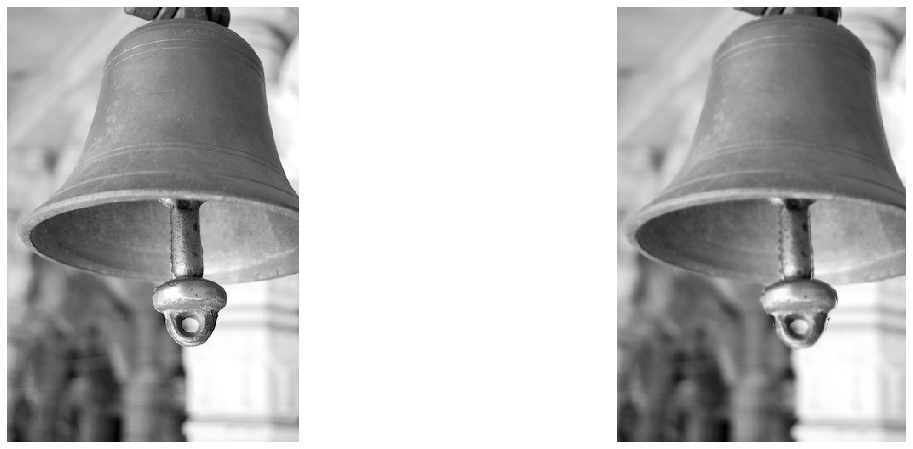

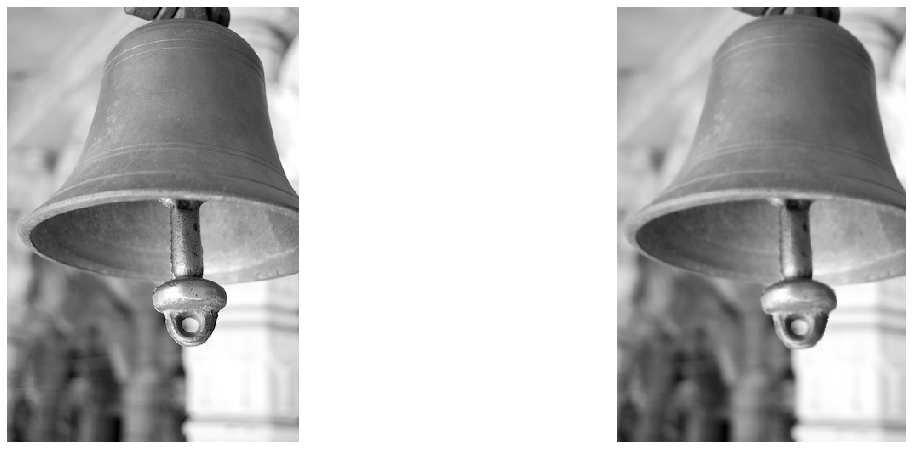

In [53]:
img = read_img(root+'bell.jpg', gray=True)
a  = invBilateralFilter(img, 1, 100, 11)
a  = bilateralFilter(img, 1, 100, 11)

---
<div width="100%" align="center"> <h1>Q8</h1></div>

---

In [54]:
img = read_img(root+'Degraded.jpg')
cimg = read_img(root+'Clear.jpg')

In [55]:
out = img
out1 = multilayer(optMedianFilter, out, k=3)

# out2 = bilateralFilter(out1, sigmad=0.5, sigmar=200, k=3, Plot=False)
# out = out1
# out = multilayer(high_boost,out2, windowSize=3, k=1, Plot=False, ret=True)
# out = bilateralFilter(out, sigmad=1, sigmar=500, k=3, Plot=False)


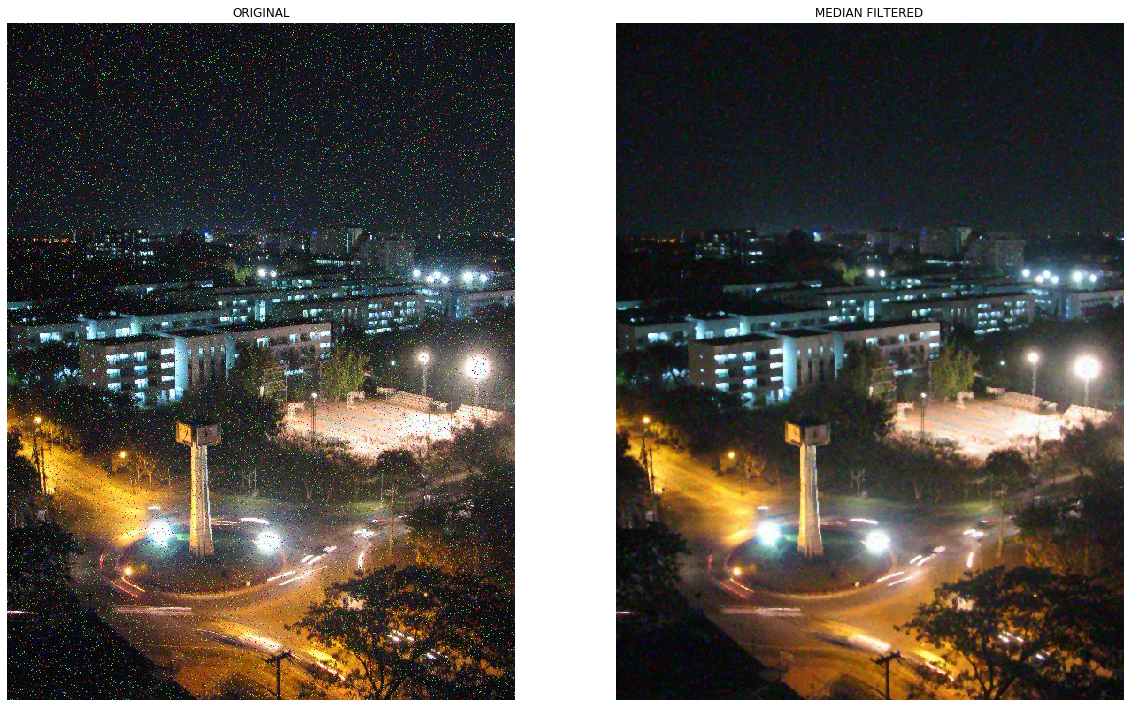

In [56]:
plot([img, out1], FigSize=(20,15), titles=['ORIGINAL', 'MEDIAN FILTERED'])

### Procedure
1. Since the noise is salt and pepper type, hence I used a median filter. It will remove any spikes inside the window range, so voth salt and pepper type noise is removed.